# This notebook is an attempt to create a model that can classify melanoma at least as good as doctors

This is my first Machine Learning project, and it is based on the following [paper](https://ieeexplore.ieee.org/document/7590963)

The dataset used to train this model comes from [kaggle](https://www.kaggle.com/drscarlat/melanoma). The dataset includes a training set of about ten thousand photos of melanoma and not melanoma cases (50% each). 

The model achieves an accuracy of about 86% on the cross-validation set, outperforming the original paper (81% accuracy).

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import transforms, datasets

## Data loading

The train data is amplified through a series of random rotations and horizontal/vertical flips. This way we get more training data for free, thus helping the model generalize better.

In [2]:
# Data directories
data_dir = '/home/ramon/Documents/MachineLearning/datasets/DermMel'

train_data_dir = data_dir + '/train_sep'
validation_data_dir = data_dir + '/valid'
test_data_dir = data_dir + '/test'

# Data augmentation
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.Resize((224, 224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
test_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
valid_transforms = test_transforms

# Data loading
train_data = datasets.ImageFolder(train_data_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_data_dir, transform=test_transforms)
valid_data = datasets.ImageFolder(validation_data_dir, transform=valid_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle = True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size = 32, shuffle=True)

classes = ['Melanoma', 'Not melanoma']

## Data visualization

We visualize the data to get a grasp of what we are working on.

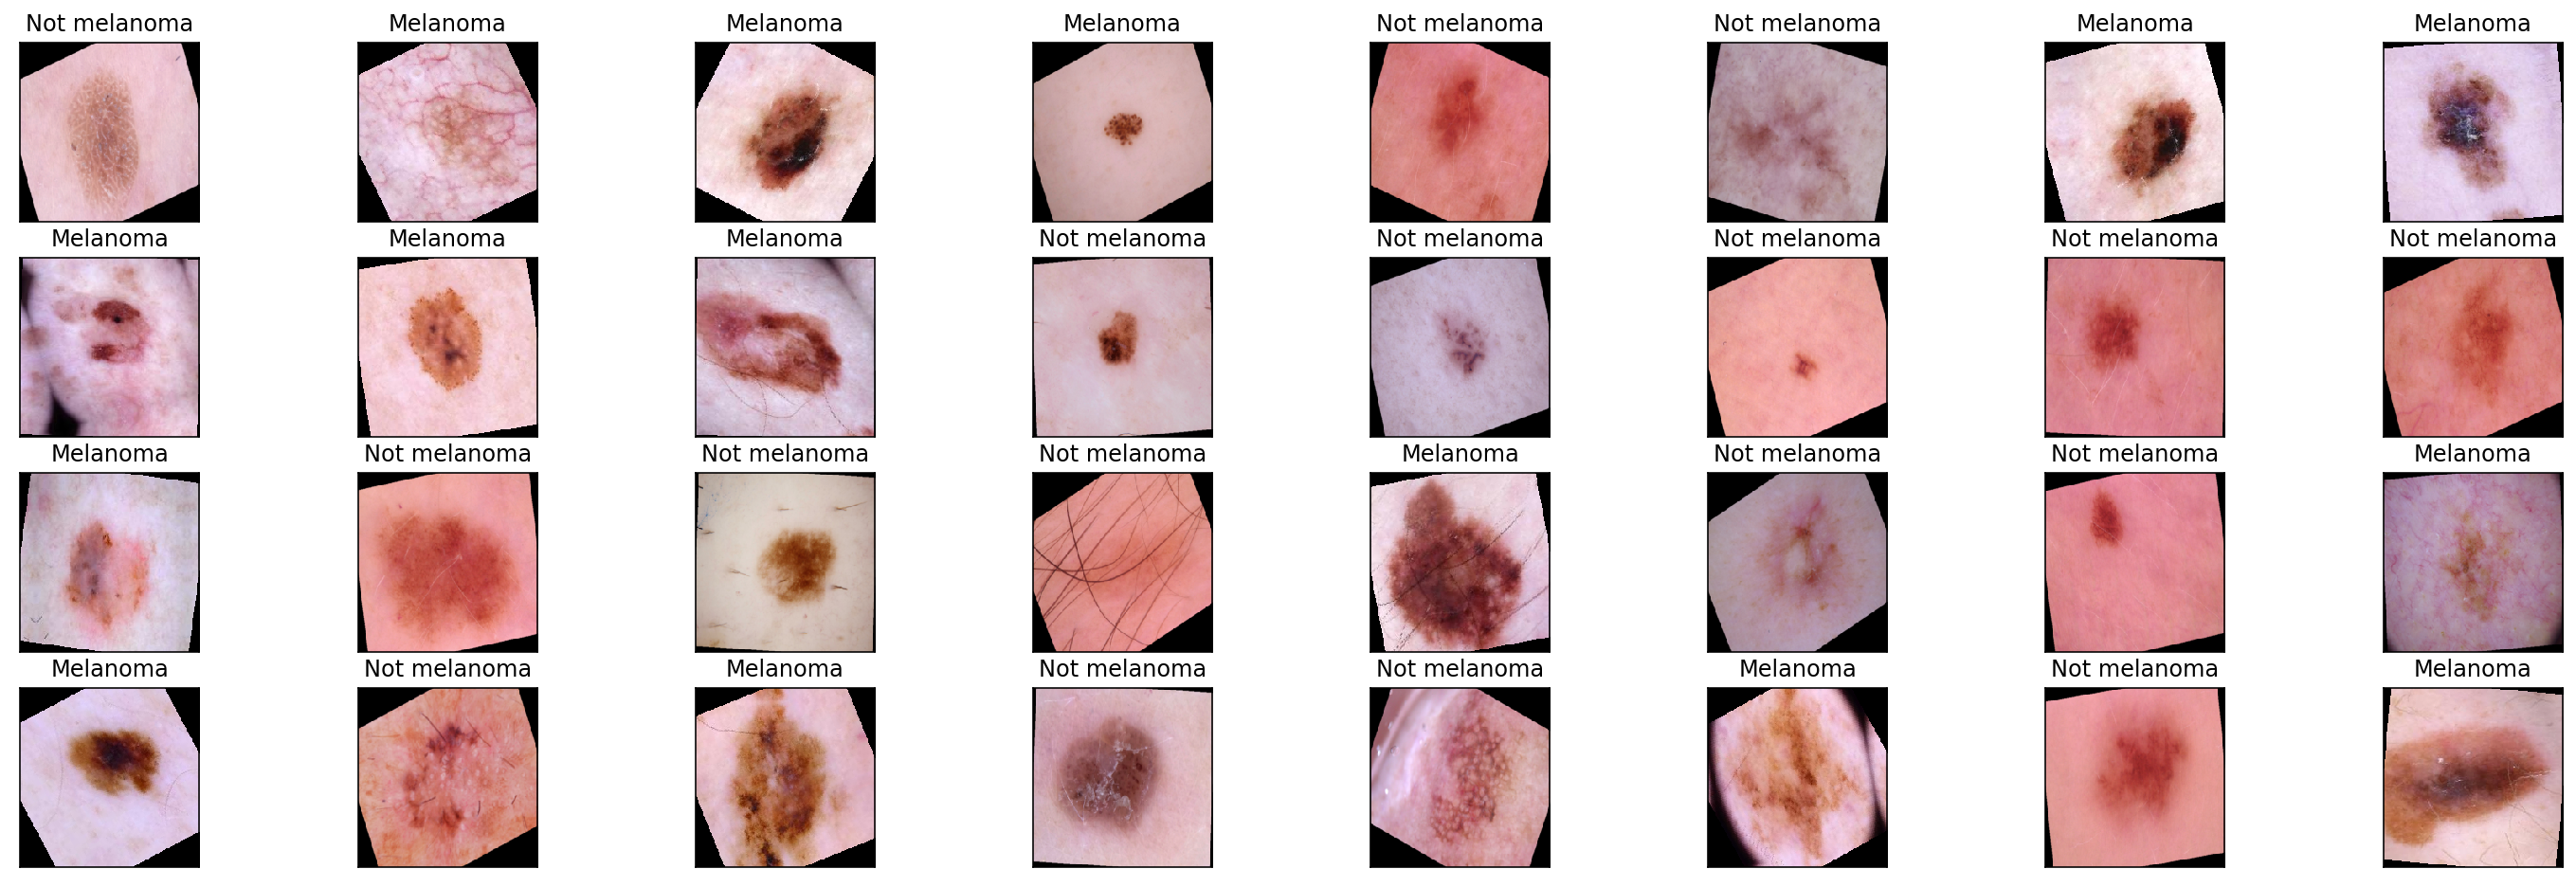

In [3]:
# Visualize loaded data

# Unnormalize data
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
images, labels = next(iter(trainloader))

# display batch
fig = plt.figure(figsize=(25, 8))
for idx in range(32):
    ax = fig.add_subplot(4, 8, idx+1, xticks=[], yticks=[])
    imshow(images[idx].numpy())
    ax.set_title(classes[labels[idx]])

## Model creation

An implementation of the neural network presented in the paper is created. The model consists of 2 convolutions followed by a max pool each, and a dense neural network as a classifier. Unlike the paper's proposed network, this classifier has one hidden layer

In [4]:
# Defining the network architecture

class MelNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 20, 5, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(4, 4)
        self.conv2 = nn.Conv2d(20, 50, 5, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(4, 4)
        
        # fully-connected layer (classifier)
        self.fc1 = nn.Linear(50 * 14 * 14, 500)
        self.fc2 = nn.Linear(500, 2)
        
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        # convolutional layer
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        
        # squeeze
        x = x.view(-1, 50 * 14 * 14)
        
        # fully connected layer (classifier)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), dim=1)
        
        return x

The model is instanced and loads previous trained state. Also, the loss criterion and optimizer are defined

In [5]:
# create model, loss function and optimizer
model = MelNet().cuda()

state_dict = torch.load('./weights_86.2.pth')
model.load_state_dict(state_dict)

criterion = nn.NLLLoss().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.003, momentum=0.9)

training_losses = []
test_losses = []
accuracies = []

## Training

The model is trained, printing the training loss once every 10 mini-batches. Also, keeps track of training losses, test_losses and accuracy. If a test_loss is smaller than any previous test losses, it saves the weights automatically.

In [19]:
# train model

epochs = 10

for e in range(epochs):
    running_loss = 0
    iteration = 0
    model.train()
    for images, labels in trainloader:
        images, labels = images.cuda(), labels.cuda()
        
        optimizer.zero_grad()
        
        log_logits = model(images)
        loss = criterion(log_logits, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        iteration += 1
        
        if iteration % 10 == 0:
            print('Epoch: {}/{}\t Iteration: {}/{}\t Running loss: {:.6f}'.format(e+1, epochs, iteration, len(trainloader), running_loss / (iteration)))
    else:
        model.eval()
        
        training_losses.append(running_loss / len(trainloader))
        
        test_loss = 0
        accuracy = 0
        with torch.no_grad():
            for images, labels in validloader:
                images, labels = images.cuda(), labels.cuda()

                log_logits = model(images)
                loss = criterion(log_logits, labels)
                test_loss += loss.item()
                logits = torch.exp(log_logits)
                _, topk = logits.topk(1, dim=1)
                equals = topk == labels.view(*topk.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
        test_losses.append(test_loss / len(validloader))
        accuracies.append(accuracy)
            
        print(f"Epoch {e+1}/{epochs}.. "
                f"Train loss: {training_losses[-1]:.3f}.. "
                f"Valid loss: {test_losses[-1]:.3f}.. "
                f"Valid accuracy: {accuracy/len(validloader):.3f}")
        
        if min(test_losses) == test_loss:
            torch.save(model.state_dict(), './weights.pth')

Epoch 1/10.. Train loss: 0.070.. Valid loss: 0.363.. Valid accuracy: 0.856
Epoch 2/10.. Train loss: 0.072.. Valid loss: 0.390.. Valid accuracy: 0.851
Epoch 3/10.. Train loss: 0.072.. Valid loss: 0.386.. Valid accuracy: 0.842
Epoch 4/10.. Train loss: 0.070.. Valid loss: 0.388.. Valid accuracy: 0.848
Epoch 5/10.. Train loss: 0.072.. Valid loss: 0.376.. Valid accuracy: 0.851
Epoch 6/10.. Train loss: 0.074.. Valid loss: 0.378.. Valid accuracy: 0.855
Epoch 7/10.. Train loss: 0.069.. Valid loss: 0.377.. Valid accuracy: 0.851
Epoch 8/10.. Train loss: 0.074.. Valid loss: 0.358.. Valid accuracy: 0.856
Epoch 9/10.. Train loss: 0.068.. Valid loss: 0.384.. Valid accuracy: 0.848
Epoch 10/10.. Train loss: 0.068.. Valid loss: 0.440.. Valid accuracy: 0.841


## Validation with test set

Given that we may inadvertedly have developed a model biased to our validation set, another pass to the test set is necessary to ensure that the model is not high variance.

In [25]:
# test model with the test set
import collections

state_dict = torch.load('./weights.pth')
model.load_state_dict(state_dict)

test_loss = 0
sensitivity = 0
accuracy = 0
for images, labels in testloader:
    images, labels = images.cuda(), labels.cuda()
    
    log_logits = model(images)
    loss = criterion(log_logits, labels)
    test_loss += loss.item()
    logits = torch.exp(log_logits)
    _, topk = logits.topk(1, dim=1)
    equals = topk == labels.view(*topk.shape)
    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    #true_equals = topk & labels.view(*topk.shape)
    
print(f"Test loss: {test_loss / len(testloader):.3f}.. "
      f"Test accuracy: {accuracy/len(testloader):.3f}.. ")

Test loss: 0.352.. Test accuracy: 0.844.. 


## Custom data

Now that we have a fully functional model, we can feed it any image to test for melanoma/not-melanoma.

Not melanoma


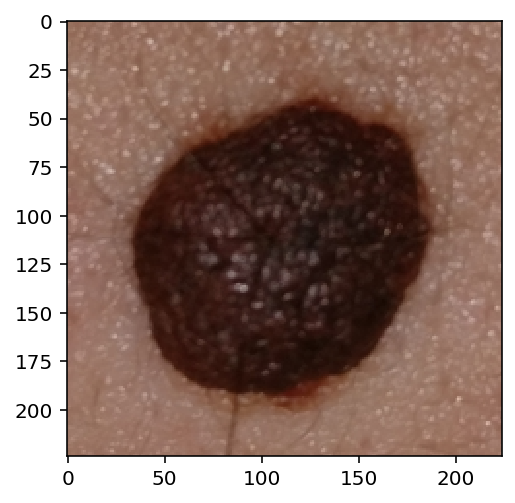

In [28]:
# Test my things
from PIL import Image

classes = ['Melanoma', 'Not melanoma']

things_dir = data_dir + '/things'

# load and show image
image = Image.open(things_dir + '/espalda1.png')
image = test_transforms(image)
image = image.view(1, *image.shape)
imshow(image[0].numpy())
# get prediction
image = image.cuda()

log_logits = model(image)
logits = torch.exp(log_logits)
_, topk = logits.topk(1, dim=1)
print(classes[topk.item()])